## The global warming issue and Narratives around it<br>
### Part 4: Performing modeling on the pickled reddit dataset

In this notebook, I set the stage for tuning and scoring the following models:

- **Logistic Regression** ---> only on vectorized text (bag of words: CountVectorizer)<br><br>
- **Naïve Bayes** ---> only on vectorized text, vectorized by CountVectorizer<br>
- **Naïve Bayes** ---> only on vectorized text, vectorized by TF-IDF vectorizer [to compare with cvec]<br><br>
- **Random forest** ---> only on vectorized text, vectorized by CountVectorizer<br>
- **Extra tress** ---> only on vectorized text, vectorized by CountVectorizer<br>
- **GBoost** ---> only on vectorized text (using CountVectorizer)<br>
- **Neural Network** ---> only on vectorized text (using CountVectorizer)<br>
- **support vector machine (SVM)** ---> only on vectorized text (using CountVectorizer)<br>

### [See the scoring table on README.md file describing all the model scores]

`- Note: In this notebook, I only studied the model performance on text documents to compare the models`



Importing the required libraries:

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import eli5

import regex as re
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from nltk.corpus import stopwords

import pickle


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Part 4.1: Importing the saved dataframe

In [2]:
df_reddit = pickle.load(open('../datasets/df_reddit_for_model.pkl', 'rb'))
df_reddit.head()

,author,created_utc,id,num_comments,over_18,post_hint,score,text_merged,subreddit,word_count*,sentiment_score*,date,target,reaction*
0,Kafka15,1593554514,hixbtf,2,0,image,1,cum,GlobalWarming,1,0.0000,2020-06-30 22:01:54,1,2
1,karan_negiiiii,1593497051,hihj6s,0,0,Empty,1,climat chang india,GlobalWarming,3,0.0000,2020-06-30 06:04:11,1,0
2,Hildavardr,1593479932,hidb5h,0,0,Empty,1,global warm respons big compani,GlobalWarming,5,0.2263,2020-06-30 01:18:52,1,0
3,pEppapiGistfuhrer,1593455137,hi5h41,1,0,image,1,ayi let stop global warm,GlobalWarming,5,-0.0772,2020-06-29 18:25:37,1,1
4,BrexitBlaze,1593455005,hi5feq,2,0,link,2,uk minist send mix messag climat commit say fu...,GlobalWarming,13,0.2960,2020-06-29 18:23:25,1,4


In [3]:
df_reddit.shape

(4828, 14)

---

## Bootstrapped the under-represented class to balance the classes:

In [4]:
n_bts_sample = df_reddit[(df_reddit["subreddit"]=="GlobalWarming")].shape[0] - df_reddit[(df_reddit["subreddit"]=="ConspiracyTheory")].shape[0]

df_btsp = df_reddit[(df_reddit["subreddit"]=="ConspiracyTheory")].sample(n = n_bts_sample, replace=True, random_state=42)

df_reddit_btsp = pd.concat([df_reddit, df_btsp])

df_reddit_btsp.reset_index(drop=True, inplace=True)

---

## Defining X and Y variables:

In [5]:
X = df_reddit_btsp['text_merged']
y = df_reddit_btsp['target']

---

## **Train/test split:**

### Defining variables

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify=y,
                                                    random_state = 101)

Checking for stratified target variables:

In [7]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

In [8]:
y_train.value_counts(normalize=True)

0    0.500085
1    0.499915
Name: target, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

1    0.500254
0    0.499746
Name: target, dtype: float64

Looks good !

## Baseline accuracy:

In [10]:
y_test.value_counts(normalize=True)

1    0.500254
0    0.499746
Name: target, dtype: float64

Hence, 50%, this is the worst we are allowed to do!

## Looking for more stop words by vectoring

In [11]:
#Adding a stop word list which I derived from an initial plot:
#list_stop_words = ["dec", "http", "www", "chang", "com"]

vectorizer = CountVectorizer(analyzer = "word",
                             #ngram_range=(1,2),
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 3000) 


X_train_features = vectorizer.fit_transform(X_train)

#X_test_features = vectorizer.transform(X_test)

In [12]:
X_train_features_df = pd.DataFrame(X_train_features.toarray(),
                          columns=vectorizer.get_feature_names())
X_train_features_df.head(2)

,abandon,abcnew,abil,abl,absolut,absorb,abus,ac,acceler,accept,...,youth,youtu,youtub,zag,zealand,zero,zeu,zig,zombi,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Looking into which words are used alot:

In [13]:
# get count of top-occurring words

# empty dictionary
top_words = {}

# loop through columns
for i in X_train_features_df.columns:
    # save sum of each column in dictionary
    top_words[i] =  X_train_features_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))
most_freq.head(10)

,0,1
0,world,1314
1,global,1304
2,warm,1238
3,http,1014
4,climat,937
5,like,911
6,peopl,862
7,chang,855
8,would,786
9,us,782


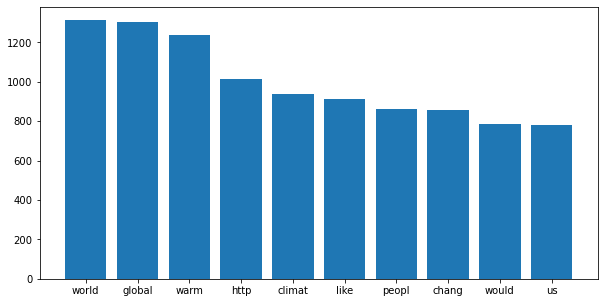

In [14]:
plt.figure(figsize = (10, 5))

# visualize top 10 words
plt.bar(most_freq[0][:10], most_freq[1][:10]);

# To remove words !

In [15]:
my_stop_words = ["dec", "global", "http", "www", "com", "conspiraci", "warm", "climat", "remov", "theori", "theactualshadow", "co"]
list_stop_words = nltk.corpus.stopwords.words('english')
list_stop_words.extend(list_stop_words)

## Now, running a baseline log-reg to look at the words that were kost/least relevant for target prediction: 

In [16]:
vectorizer = CountVectorizer(analyzer = "word",
                             #ngram_range=(1,2),
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = list_stop_words,
                             max_features = 3000) 


X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

In [17]:
lr = LogisticRegression(solver='newton-cg')

In [18]:
lr.fit(X_train_features, y_train);

In [19]:
lr.score(X_train_features, y_train)

0.9883070665988816

In [20]:
lr.score(X_test_features, y_test)

0.9684799186578547

Creating a dataframe to look at the coefficient of the basae model:

In [21]:
df_coeffs = pd.DataFrame()
df_coef= pd.DataFrame(lr.coef_).T
df_feat = pd.DataFrame(vectorizer.get_feature_names())

df_lr_coefs=pd.concat([df_feat, df_coef], axis=1)
df_lr_coefs.columns = ["feature_names", "LR_coefficients"]
df_lr_coefs_sorted = df_lr_coefs.sort_values(by =["LR_coefficients"], ascending=False, ignore_index=True)
df_lr_coefs_sorted

,feature_names,LR_coefficients
0,warm,3.246521
1,climat,3.169724
2,carbon,2.244756
3,environment,1.959483
4,temperatur,1.765794
...,...,...
2995,theori,-2.048903
2996,alien,-2.088732
2997,ufo,-2.116584
2998,practic,-2.666791


In [22]:
df_lr_coefs_sorted.head(10)

,feature_names,LR_coefficients
0,warm,3.246521
1,climat,3.169724
2,carbon,2.244756
3,environment,1.959483
4,temperatur,1.765794
5,ice,1.695237
6,green,1.685874
7,futur,1.648235
8,co,1.620086
9,environ,1.542935


In [23]:
df_lr_coefs_sorted.tail(10)

,feature_names,LR_coefficients
2990,light,-1.614210
2991,illuminati,-1.687637
2992,moon,-1.844656
2993,contribut,-1.905608
2994,conflict,-1.915085
2995,theori,-2.048903
2996,alien,-2.088732
2997,ufo,-2.116584
2998,practic,-2.666791
2999,conspiraci,-2.976506


In [24]:
df_lr_coefs_sorted.shape

(3000, 2)

## Part 4.2- **Logistic Regression**
## only on vectorized text (bag of words: CountVectorizer)

Designing the pipe:

In [25]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [26]:
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': [list_stop_words],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [27]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [28]:
gs.fit(X_train, y_train);

In [29]:
gs.best_params_;

In [30]:
# Score model on training set.
gs.score(X_train, y_train)

0.992204711065921

In [31]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9720386375190646

In [32]:
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall

(0.9720386375190646, 0.9813471502590674, 0.9623983739837398)

## Part 4.3- **Naïve Bayes** <br><br>(only on vectorized text, vectorized by CountVectorizer)

#### Designing a pipeline for Bayes analysis to fine-tune the model and get best scores

In [33]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [34]:
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': [list_stop_words],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [35]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [36]:
gs.fit(X_train, y_train);

In [37]:
gs.best_params_;

In [38]:
# Score model on training set.
gs.score(X_train, y_train)

0.9437383494322996

In [39]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9328927300457549

In [40]:
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall

(0.9328927300457549, 0.9561027837259101, 0.907520325203252)

## Part 4.4- **Naïve Bayes** <br><br>(only on vectorized text, vectorized by TF-IDF vectorizer)

In [41]:
# Instantiate the transformer.
tvec = TfidfVectorizer()

In [42]:
df = pd.DataFrame(tvec.fit_transform(X_train).toarray(),
                  columns=tvec.get_feature_names())
df.head()

,aa,aacgtmjui,aaliyah,aaron,aass,ab,aback,abandon,abbott,abbrevi,...,zombi,zone,zoo,zorgt,zq,zr,ztiu,zuckerberg,zvhm,zwhvc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Designing a pipeline for TF-IDF analysis

In [43]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [44]:
# Search over the following values of hyperparameters:
# Source: http://freediscovery.io/doc/stable/python/examples/optimize_tfidf.html

pipe_tf_idf_params = {
              'tfidf__use_idf': (True, False),}


In [45]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe_tfidf, # what object are we optimizing?
                        param_grid = pipe_tf_idf_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [46]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train);

In [47]:
# Score model on training set.
gs.score(X_train, y_train)

0.9744111167598712

In [48]:
# Score model on testing set.
gs.score(X_test, y_test)

0.951194712760549

In [49]:
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall

(0.951194712760549, 0.9847161572052402, 0.9166666666666666)

<Figure size 1440x1152 with 0 Axes>

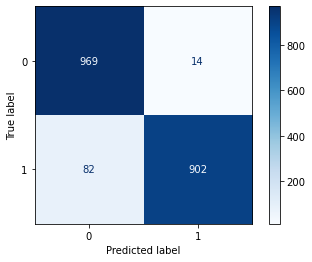

In [50]:
# visualize this
plt.figure(figsize=(20,16))

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.savefig("../plots/Confusion.png")

## Part 4.5- **Random forest** <br> <br> (only on vectorized text, vectorized by CountVectorizer)

Create an instance of RandomForestClassifier.

In [51]:
rf = RandomForestClassifier()


rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train_features, y_train)
print(gs.best_score_)
gs.best_params_

0.959668192712295


{'max_depth': None, 'n_estimators': 100}

In [52]:
# Score model on training set.
gs.score(X_train_features, y_train)

0.9969496695475343

In [53]:
# Score model on testing set.
gs.score(X_test_features, y_test)

0.9761057447890188

In [54]:
preds = gs.predict(X_test_features)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall

(0.9761057447890188, 0.9905759162303664, 0.9613821138211383)

<Figure size 1440x1152 with 0 Axes>

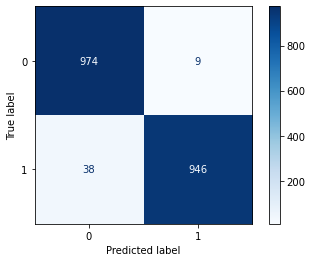

In [55]:
# visualize this
plt.figure(figsize=(20,16))

plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');
plt.savefig("../plots/Confusion.png")

## Part 4.6- **Extra tress** <br> <br> (only on vectorized text, vectorized by CountVectorizer)

Create an instance of ExtraTreesClassifier.

In [56]:
et = ExtraTreesClassifier(n_estimators=100)


rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(et, param_grid=rf_params, cv=5)
gs.fit(X_train_features, y_train)
print(gs.best_score_)
gs.best_params_

0.9630575926749811


{'max_depth': None, 'n_estimators': 200}

In [57]:
gs.score(X_train_features, y_train)

0.9969496695475343

In [58]:
gs.score(X_test_features, y_test)

0.9796644636502287

In [59]:
preds = gs.predict(X_test_features)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall

(0.9796644636502287, 0.9896265560165975, 0.9695121951219512)

## Part 4.7- **GBoost** <br> <br> only on vectorized text (using CountVectorizer)

Create an instance of GradientBoostingClassifier.

In [60]:
gboost = GradientBoostingClassifier()
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gs = GridSearchCV(gboost, param_grid=gboost_params, cv=3)
gs.fit(X_train_features, y_train)
print(gs.best_score_)
gs.best_params_

0.8788340959159465


{'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150}

In [61]:
gs.score(X_train_features, y_train)

0.9034062023385867

In [62]:
gs.score(X_test_features, y_test)

0.8779867819013727

In [63]:
preds = gs.predict(X_test_features)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall

(0.8779867819013727, 0.9907651715039578, 0.7632113821138211)

## Part 4.8- **Neural Network** <br> <br> only on vectorized text (using CountVectorizer)

In [64]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [65]:
mlp.fit(X_train_features,y_train)

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [66]:
mlp.score(X_train_features, y_train)

0.9969496695475343

In [67]:
mlp.score(X_test_features, y_test)

0.9700050838840875

In [68]:
preds = mlp.predict(X_test_features)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall

(0.9700050838840875, 0.9894179894179894, 0.9502032520325203)

## Part 4.9- **support vector machine (SVM)** <br> <br> only on vectorized text (using CountVectorizer)

In [69]:
svc = SVC(
    C = 100,
    kernel = "rbf",
    gamma = "scale"
)

# Fit on training data.
svc.fit(X_train_features, y_train)

SVC(C=100)

In [70]:
svc.score(X_train_features, y_train)

0.9955939671242162

In [71]:
# Evaluate model.
accuracy_score(y_test, svc.predict(X_test_features))

0.9649211997966446

In [72]:
preds = svc.predict(X_test_features)


# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall


(0.9649211997966446, 0.9893048128342246, 0.9400406504065041)

## Model conclusions:

- Conclusion from this notebook: Stemming the words, and using TF-IDF vectorizer rather than CountVectorizer helped the accuracy to a limited extent (by maximum 3%). Among several tested classification models, they had a precision values higher than 96% and Recall values higher than 92% on test set.
    
- Also, the models seemed to be slightly overfit (<2%). From the text vectorizers, tf-idf seemed to be faster and resulted in better scores. Also, random forest gave the best results. As a next stage in the modeling, I decided to also take the numerical features into consideration. Hence, I chose Logistic Regression model to proceed with at it provides a better sense on the feature importance and how much they contribute to the model. It also allows u sto test our engineered numeric features. Next section focuses on the text-numerics combined feature model using Logistic Regression.

In [74]:
print("Hello world!")

Hello world!
